In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset
import torch.utils.data as data
import os
import matplotlib.image as mpimg
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
root_dir="/workspace/Shantan_Data/Bayesian2v/Auto1/All/"

In [ ]:
import pandas as pd

In [ ]:
class AutoDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None,target_transform=None,device='cuda:1'):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = mpimg.imread(img_path)
        label = self.annotations.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image,label

In [11]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((300, 300)),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
batch_size = 32
num_workers = 0

In [ ]:
dataset= AutoDataset(csv_file='/workspace/Shantan_Data/Bayesian2v/Auto1/Multi.csv',root_dir="/workspace/Shantan_Data/Bayesian2v/Auto1/All",transform=transform,target_transform=None)


In [ ]:
from torch.utils.data import DataLoader

In [14]:
proportions = [.75, .10, .15]
lengths = [int(p * len(dataset)) for p in proportions]
lengths[-1] = len(dataset) - sum(lengths[:-1])
train_set, val_set, test_set = data.random_split(dataset, lengths)

In [15]:
trainloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

classes = (0,1)

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This ty

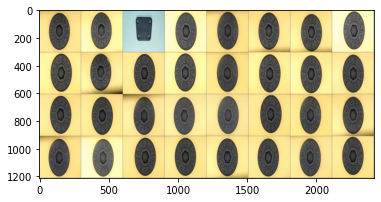

0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [16]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d((1,1))
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(128,2)
        
    def forward(self, x):
        bs= x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        x = self.pool1(x)
        x = torch.reshape(x,(bs,-1))
        x = self.fc1(x)
        return x

In [18]:
net = Net()
net=net.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(200): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:   
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/opt/conda/lib/python3.8/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This ty

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(100)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]] for j in range(15)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [ ]:
from sklearn.metrics import confusion_matrix